In [5]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

___
Enter Team Member Names here (double click to edit):

DJ Dawkins, Rick Fontenot, Joe Lazarus, Puri Rudick

________

# In Class Assignment Four
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook) before the end of class. Be sure to save the notebook before uploading!

<a id="top"></a>
## Contents
* <a href="#cluster">Create Clustering Data</a>
* <a href="#kmeans">K-means Clustering</a>
* <a href="#mini">MiniBatch K-Means</a>
* <a href="#dbscan">Using DBSCAN</a>

________________________________________________________________________________________________________
<a id="cluster"></a>
<a href="#top">Back to Top</a>
## Clustering
Please run the following code to create synthetic datasets on a two dimensional plane. Three sets of data are created and saved into variables `X1`, `X2`, and `X3`. Each dataset is plotted afterward. We will be using `scikit-learn` to perform clustering on each dataset. You do not need to understand the specifics of the code in the next block, just know that three datasets are created with two attributes in each dataset (*i.e.*, two columns), and they are saved into variables `X1`, `X2`, and `X3`.

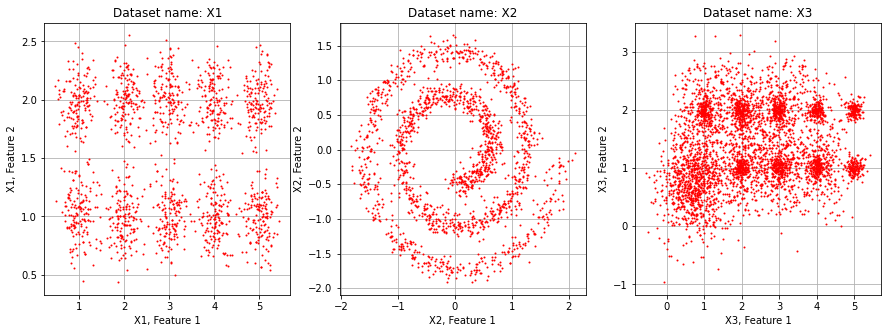

In [7]:
# getting things started
from __future__ import print_function
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np


# generate some sample data
n_samples = 1700
np.random.seed(0)

#======= Sample data ONE
cluster_centers = [[1.0,1], [1,2], [2,1], [2,2], [3,1], [3,2], [4,1], [4,2], [5,1], [5,2]]
X1 = np.array(cluster_centers) # cluster prototypes
X1 = np.repeat(X1, 150, axis=0)
X1 += .2 * np.random.randn(X1.shape[0],2) # add some randomness

#====== Sample data TWO
# Generate some harder sample data
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t) / 10.0
y = t * np.sin(t) / 10.0

X2 = np.concatenate((x, y))
X2 += .1 * np.random.randn(2, n_samples) # add some randomness
X2 = X2.T # and transpose it

#====== Sample data THREE
cluster_centers[0] = [0.75,0.75]
cluster_centers.insert(0,[0.75,0.75])
X3 = np.array(cluster_centers) # cluster prototypes
X3 = np.repeat(X3, 150, axis=0)
X3 += .1 * np.random.randn(X3.shape[0],2) # add some randomness
X3[0:300] += .3 * np.random.randn(300,2) # add spread to first class

n_samples = int(len(X3)/4*3)
Xtmp1 = X3[0:n_samples] + .4 * np.random.randn(n_samples,2) # create some spread in the points
Xtmp2 = X3[0:n_samples] + .4 * np.random.randn(n_samples,2) # create some spread in the points
X3 = np.concatenate((X3,Xtmp1,Xtmp2)) # and add them back in for differing density

# now plot each dataset
plt.figure(figsize=(15,5))
for i,X in enumerate([X1,X2,X3]):
    plt.subplot(1,3,i+1)
    plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
    plt.title('Dataset name: X{0}'.format(i+1))
    plt.xlabel('X{0}, Feature 1'.format(i+1))
    plt.ylabel('X{0}, Feature 2'.format(i+1))
    plt.grid()

plt.show()

**Questions**: For each dataset, is it: 
- best described as center-based, contiguous, or density based (or a mix of more than one)? 
- best described as partitional or hierarchical?  

**Question**: Given the plots above for each dataset, what type of clustering algorithm would you consider using for each and why? That is, give your opinion on whether k-means, hierarchical agglomerative, and/or DBSCAN are appropriate for each dataset.

___
Enter your answer here:

*X1:** Appears to be center-based and partitional (unnested). We would suggest k-means clustering for this set because of the visually separated clusters with centroids and lack of density concentrations or nesting. DBSCAN could also be appropraite and possibly run faster.

**X2:** The spiral shape is contiguous and partitional (unnested). We would recommend DBSCAN because it can discover non-convex clusters like this spiral and can work without a specified number of clusters and leave the noise (in gaps between spiral) out of the clustering

**X3:** There are definitely density based clusters. Argument could be made that the 9 densest clusters are nested inside of a larger cluster in which case it would be hierarchical and that hierarchical agglomerative clustering seems most appropriate to look at the groups inside of groups. However it could also be argued that they are not inside of larger clusters and that the rest is just noise. In this case DBSCAN could be appropriate.


___

___
<a id="kmeans"></a>
<a href="#top">Back to Top</a>
## Kmeans Clustering in Scikit
Now lets look at calculations in K-Means clustering with `scikit-learn` and see if we can calculate the difference between two different clusterings. Lets start by using k-means clustering on the first dataset. The code is given for you below as well as code for plotting the centroids, as shown. Take a look to see how k-means is run.

You can also see the documentation for k-means here:
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


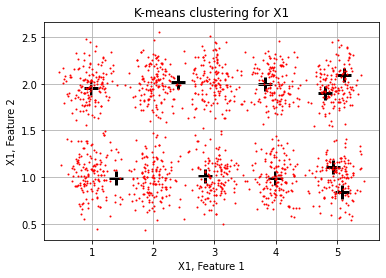

In [8]:
from sklearn.cluster import KMeans

# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(init='random', # initialization
        n_clusters=10,  # number of clusters
        n_init=1,       # number of different times to run k-means
        n_jobs=-1)

kmeans.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

**Questions**: 
- Is the above a good clustering of the data? Why or why not? 
- Run the block of code a few times. Did the results ever improve? Is the clustering consistent? 
- How might we make the clustering more consistent in finding the optimal clustering (i.e., the clustering with the smallest SSE)?

___
Enter your answer here:

This is not representative of a good clustering of the data because some of the visual clusters get two centroids within them while others may have a centroid shared in the space between them. Running the code multiple times moves the centroids (not consistent) and the same issues still exist. Because of the random assignment of initial centroids, more than one centroid may be introduced into a similar group bringing about poor clustering. 

We might be able to improve this by using k-means++ to increase the odds of getting centroids that are further apart. We may be able to make it more consistent by increasing the n_init to run the algorith multiple times to get the best output of n_init consecutive runs in terms of inertia.

___


___
## K-means consistency
**Exercise**: Now let's try to make the kmeans clustering more consistent. Change the `n_init` and `init` parameters of kmeans such that (almost) every time you run the block of code, the optimal clustering is found. Make sure that the solution you find is as *efficient as possible*.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


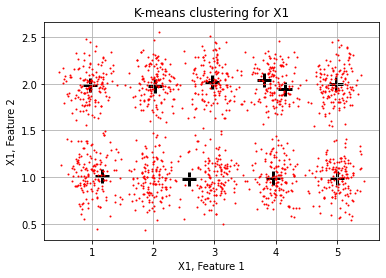

In [10]:
from sklearn.cluster import KMeans

#--------Change parameters below this line---------------------------
# CHANGE THE PARAMETERS HERE TO GET A CONSISTENTLY OPTIMAL CLUSTERING
# run kmeans algorithm (this is the most traditional use of k-means)
kmeans = KMeans(
    init='random',    # initialization
    n_clusters=10,    # number of clusters
    n_init=1,         # number of different times to run k-means
    n_jobs=-1)
#--------Change parameters above this line---------------------------

kmeans.fit(X1)

# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

Random Init, n_init=1, SSE=  171.0661584858424
Random Init, n_init=10, SSE=  109.87509274288402
k-means++ Init, n_init=1, SSE=  109.87509274288405
k-means++ Init, n_init=10, SSE=  109.87509274288402


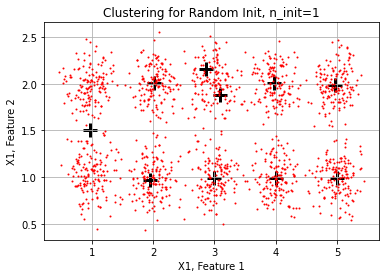

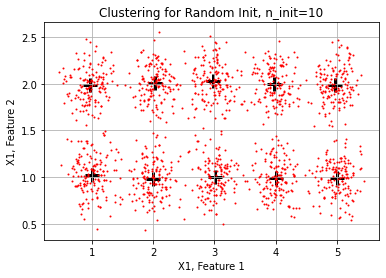

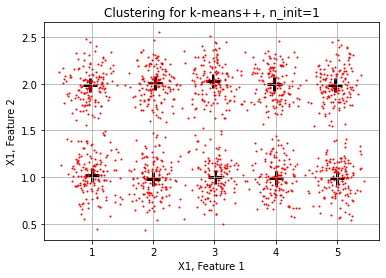

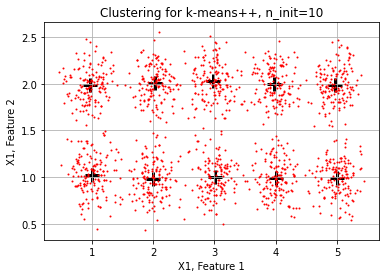

In [12]:
import warnings
warnings.filterwarnings("ignore")

kmeans1 = KMeans(init='random',  n_clusters=10, n_init=1, n_jobs=-1)
kmeans1.fit(X1)
print('Random Init, n_init=1, SSE= ',kmeans1.inertia_)

kmeans2 = KMeans(init='random',  n_clusters=10, n_init=10, n_jobs=-1)
kmeans2.fit(X1)
print('Random Init, n_init=10, SSE= ',kmeans2.inertia_)

kmeans3 = KMeans(init='k-means++',  n_clusters=10, n_init=1, n_jobs=-1)
kmeans3.fit(X1)
print('k-means++ Init, n_init=1, SSE= ',kmeans3.inertia_)

kmeans4 = KMeans(init='k-means++',  n_clusters=10, n_init=10, n_jobs=-1)
kmeans4.fit(X1)
print('k-means++ Init, n_init=10, SSE= ',kmeans4.inertia_)

centroids = kmeans1.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('Clustering for Random Init, n_init=1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

centroids = kmeans2.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('Clustering for Random Init, n_init=10')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

centroids = kmeans3.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('Clustering for k-means++, n_init=1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

centroids = kmeans4.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k')  # plot the centroids
plt.title('Clustering for k-means++, n_init=10')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

In [13]:
start_time = time.time()
SSE1 = np.zeros((100,1))
for i in range(100):
    kmeans1 = KMeans(init='random',  n_clusters=10, n_init=1, n_jobs=-1)
    kmeans1.fit(X1)
    SSE1[i] = kmeans1.inertia_
print('Random Init, n_init=1, MIN SSE =',round(SSE1.min(),1), ' MAX SSE = ',round(SSE1.max(),1), 'Run Time: ',round(time.time() - start_time,1), 'seconds')

start_time = time.time()
SSE2 = np.zeros((100,1))
for i in range(100):
    kmeans2 = KMeans(init='random',  n_clusters=10, n_init=10, n_jobs=-1)
    kmeans2.fit(X1)
    SSE2[i] = kmeans2.inertia_
print('Random Init, n_init=10: MIN SSE =',round(SSE2.min(),1), ' MAX SSE = ',round(SSE2.max(),1), "Run Time: ",round(time.time() - start_time,1), "seconds")

start_time = time.time()
SSE3 = np.zeros((100,1))
for i in range(100):
    kmeans3 = KMeans(init='k-means++',  n_clusters=10, n_init=1, n_jobs=-1)
    kmeans3.fit(X1)
    SSE3[i] = kmeans2.inertia_
print('k-means++ Init, n_init=1: MIN SSE =',round(SSE3.min(),1), ' MAX SSE = ',round(SSE3.max(),1), "Run Time: ",round(time.time() - start_time,1), "seconds")

start_time = time.time()
SSE4 = np.zeros((100,1))
for i in range(100):
    kmeans4 = KMeans(init='k-means++',  n_clusters=10, n_init=10, n_jobs=-1)
    kmeans4.fit(X1)
    SSE4[i] = kmeans2.inertia_
print('k-means++ Init, n_init=10: MIN SSE =',round(SSE4.min(),1), ' MAX SSE = ',round(SSE4.max(),1), "Run Time: ",round(time.time() - start_time,1), "seconds")

Random Init, n_init=1, MIN SSE = 109.9  MAX SSE =  245.0 Run Time:  0.7 seconds
Random Init, n_init=10: MIN SSE = 109.9  MAX SSE =  165.2 Run Time:  7.1 seconds
k-means++ Init, n_init=1: MIN SSE = 109.9  MAX SSE =  109.9 Run Time:  0.6 seconds
k-means++ Init, n_init=10: MIN SSE = 109.9  MAX SSE =  109.9 Run Time:  5.0 seconds


### When using Random Initialization there are times model meets minimum SSE but it's not consistent even after increasing n_init from 1 to 10

### Using k-means++ provides consistency on SSE even with n_init as low as 1. Increasing n_init does not further reduce SSE but does increase run time.

### Using k-means++ with n_init=1 appears to be the most efficient

___
# Start of Live Sesion Assignment

<a id="mini"></a>
<a href="#top">Back to Top</a>
## Mini-batching for better performance
Traditional Kmeans uses a "Batch" approach where each point is looked at for every iteration. By incrementally updating the centroids in the space, we can get a more efficient way of finding the centroids without visiting every point in the dataset at each iteration. We talked about this in the video lecture and it was called "Mini-Batch Kmeans." The following code will run both kmeans and mini-batch kmeans using `scikit-learn`'s implementations. The mini-batch size is set currently to ten instances. Each algorithm is timed for each run and the times are shown after the block of code (I am using the `%time` magics for ipython). Answer the questions that follow this block of code.


Time for BatchKMeans:
CPU times: user 201 ms, sys: 71.2 ms, total: 273 ms
Wall time: 79.1 ms
Time for MiniBatchKMeans:
CPU times: user 395 ms, sys: 133 ms, total: 528 ms
Wall time: 138 ms


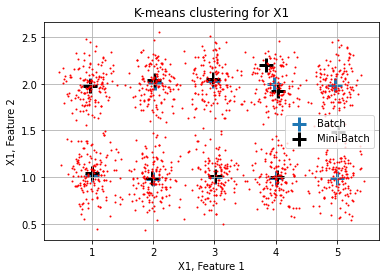

In [54]:
from sklearn.cluster import MiniBatchKMeans

kmeans_mini = MiniBatchKMeans(n_clusters=10, batch_size=10)
kmeans = KMeans(n_clusters=10)

print('Time for BatchKMeans:')
%time kmeans.fit(X1)
print('Time for MiniBatchKMeans:')
%time kmeans_mini.fit(X1)


# visualize the data
centroids = kmeans.cluster_centers_
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')  # plot the centroids

centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')  # plot the centroids
plt.legend()
plt.title('K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

In [55]:
# Use this space for any calculations you may want to perform for the objective function

print('Batch objective function value:', kmeans.inertia_)
print('Mini-Batch objective function value:', kmeans_mini.inertia_)

Batch objective function value: 109.87509274288405
Mini-Batch objective function value: 180.66995280680595


**Questions**: 
- Is mini-batch faster than kmeans for this example? Does this make sense to you? Why or why not?
- Are the results comparable to one another? 
 - To compare the results mathematically, what objective function would you use?
 - Does `scikit-learn`'s implementation have a property in the fitted object for getting the value of this objective function?
 - If so, compare the objective function value for the `kmeans` object and the `kmeans_mini` object. Which is better?

___
Enter your answer here:

* Mini-batch seems to be faster most of the time but 1 out of 10 runs it actually ran slower. When we increased batch size to 100 mini-batch seems to be more consistently faster. From docuemtation batch_size defaults to 1024. For faster compuations, you can set the batch_size greater than 256 * number of cores to enable parallelism on all cores. [ref](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html)

* Upon running multiple times the results are not always comparable; mini-batch centroids are sometimes off center from the clusters while the full kmeans is more consistent

* To compare the results mathmateically we can compare SSE between the functions.

* In sklearn you can obtain SSE with the inertia_ calcualtions from the fit of k-means where the Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. [ref](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

* The SSE for the batch function (110) is better (lower) than the mini-batch function (181). The SSE results for mini-batch seem to be 'close' to the optimal found by kmeans, they are not quite optimal. 
___


___
<a id="dbscan"></a>
<a href="#top">Back to Top</a>
## DBSCAN 
Now lets use the remaining datasets to investigate the use of DBSCAN clustering. As a reminder, this is what the two datasets look like:

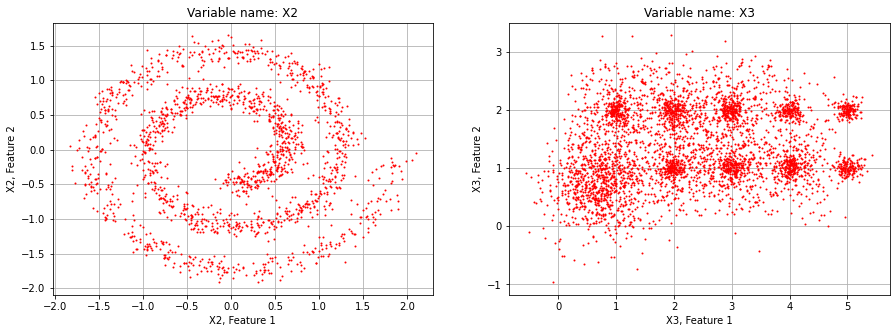

In [56]:
from sklearn.cluster import DBSCAN

# now plot each dataset
plt.figure(figsize=(15,5))
for i,X in enumerate([X2,X3]):
    plt.subplot(1,2,i+1)
    plt.plot(X[:, 0], X[:, 1], 'r.', markersize=2) #plot the data
    plt.title('Variable name: X{0}'.format(i+2))
    plt.xlabel('X{0}, Feature 1'.format(i+2))
    plt.ylabel('X{0}, Feature 2'.format(i+2))
    plt.grid()

plt.show()

___
Recall that with DBSCAN, we need to set the values for eps and for MinPts to create core points, border points, and noise points. 

**Question**: Can you come up with a reasonable value for *eps* and *MinPts* from the above graphs? What are your guesses and why did you choose them?
  

___
Enter your answer here:

Minimum points 
•	Many different values will work here, but we should be looking for a value of minpts that minimizes the slope of the line in the plots below. A lesser slope signifies more consistent neighbor distances. Its hard to tell directly from the data what the value should be. For X2, though, the value of eps should be about half the size of the width of swirl. About 0.1-0.2. For X3, the value should be less than the density of the noise points in the bottom left corner, maybe around 0.1.

For X2: the plots below show the elbow for eps around 0.1 when minPts = 4, but when MinPts = 16 the eps elbow is around 0.2

For X3: the plots below show the elbow for eps around 0.06 when minPts = 4, but when MinPts = 16 the eps elbow is around 0.1

___

Now, let's investigate the value of MinPts and eps for the given datasets by graphing out the distances to the $N^{th}$ nearest neighbors (as we did at the end of the lecture video). This example sets N=4, but you can change it to be whatever value you think is reasonable from above. You can also try changing the value to find a better graph.

The code below will calculate and graph the distances to the $N^{th}$ nearest neighbors for each dataset (the variable names are `X2_N` and `X3_N`). **Exercise**: Investigate the graphs at the end and choose a value of MinPts and Eps for each dataset. **Question**: What is the value of Eps and MinPts and why do you think it will work given these graphs?

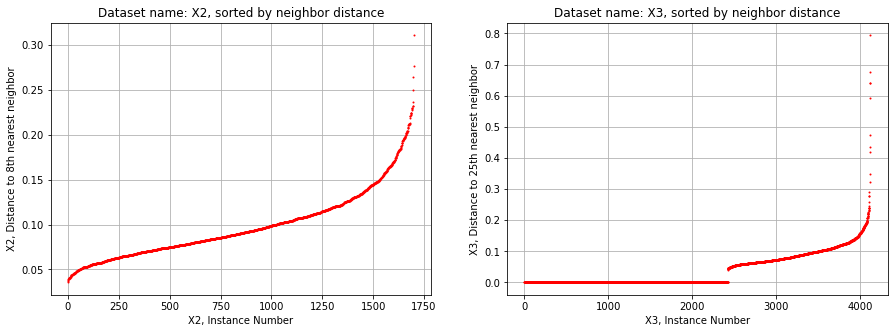

In [68]:
# lets first look at the connectivity of the graphs and distance to the nearest neighbors
from sklearn.neighbors import kneighbors_graph

#=======================================================
# CHANGE THESE VALUES TO ADJUST MINPTS FOR EACH DATASET
X2_N = 8
X3_N = 25
#=======================================================

# create connectivity graphs before calcualting the hierarchy
X2_knn_graph = kneighbors_graph(X2, X2_N, mode='distance') # calculate distance to four nearest neighbors 
X3_knn_graph = kneighbors_graph(X3, X3_N, mode='distance') # calculate distance to four nearest neighbors 

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = np.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = np.sort(X2_4nn_distances, axis=0)

N3 = X3_knn_graph.shape[0]
X3_4nn_distances = np.zeros((N3,1))
for i in range(N2):
    X3_4nn_distances[i] = X3_knn_graph[i,:].max()

X3_4nn_distances = np.sort(X3_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X2, sorted by neighbor distance')
plt.xlabel('X2, Instance Number')
plt.ylabel('X2, Distance to {0}th nearest neighbor'.format(X2_N))
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(N3), X3_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: X3, sorted by neighbor distance')
plt.xlabel('X3, Instance Number')
plt.ylabel('X3, Distance to {0}th nearest neighbor'.format(X3_N))
plt.grid()

plt.show()

___
Enter your answer here:

What is the value of Eps and MinPts and why do you think it will work given these graphs?
•	For X2, there is a marked increase at about 0.15 on the graph (though any value near this will be reasonable). For X3, the noise points greatly extend the tail of X3 upward, and the value of minpts may need to be heavily increased. Given N of about 15, the value of eps seems to be about 0.1 or maybe slightly higher.
•	If you are still having trouble with minpts and eps for x2 and x3, try 8 and 25 for min pts and 0.17 and 0.12 for eps.  However, this is not the only correct answer!  You may find a combination of values that you prefer better! 

MinPts = 10, X2 eps=0.15, X3 eps = 0.1
MinPts = 20, X2 eps=0.24, X3 eps = 0.14

X2: min=7 eps=0.14
X3: min=30 eps=0.18

___

___
## DBSCAN testing eps and minpts
Now test your values of eps from the above question for each dataset. The code below will train and plot clusters with the given parameters. **Analysis**: Enter your chosen MinPts and Eps parameters for each dataset and analyze the output. 
- Do the parameters you chose for these datasets end up with valid clusterings? Why or why not? 
- What range of parameters would give valid clusterings for each dataset? 

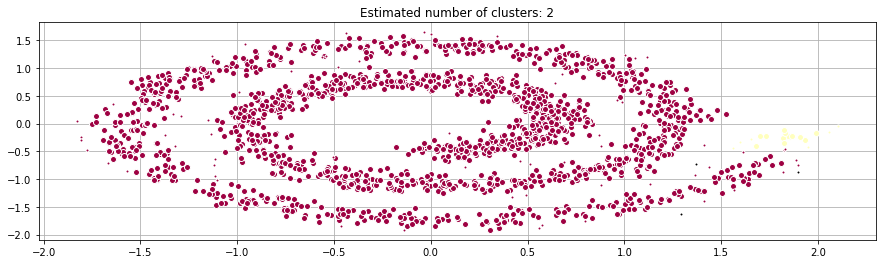

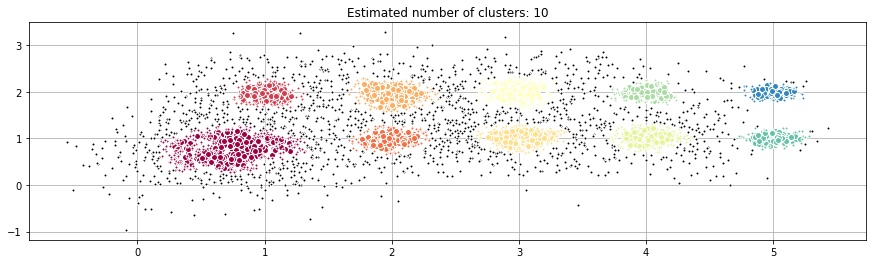

In [71]:
from sklearn.cluster import DBSCAN

#Our estimates from re-running plots above
#For X2: the plots below show the elbow for eps around 0.1 when minPts = 4, but when MinPts = 16 the eps elbow is around 0.2
#For X3: the plots below show the elbow for eps around 0.06 when minPts = 4, but when MinPts = 16 the eps elbow is around 0.1
#MinPts = 10, X2 eps=0.15, X3 eps = 0.1
#MinPts = 20, X2 eps=0.24, X3 eps = 0.14
#X2: min=7 eps=0.14
#X3: min=30 eps=0.18

#From hint
#X2: MinPts=8, eps=0.17
#X3: MinPts=25, eps=0.12

#=====================================
# ENTER YOUR CODE HERE TO CHANGE MINPTS AND EPS FOR EACH DATASET
X2_minpts = 8 # from above
X2_eps = 0.17
X3_minpts = 25 # from above
X3_eps = 0.12
#=====================================

for i, (data, minpts, eps) in enumerate(zip([X2,X3],[X2_minpts,X3_minpts],[X2_eps,X3_eps])):

    db = DBSCAN(eps=eps, min_samples=minpts).fit(data)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # mark the samples that are considered "core"
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=(15,4))
    unique_labels = set(labels) # the unique labels
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        # plot the core points in this class
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=6)

        # plot the remaining points that are edge points
        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='w', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.grid()
    plt.show()

___
Enter your answer here:

**Do the parameters you chose for these datasets end up with valid clusterings? Why or why not?**
* It depends on which parameters you choose. We examined graphs to find the elbow indicating reasonable eps for a range of MinPts. Some of them provided valid clusterings although the amount and size of clusters still varied significantly.

**What range of parameters would give valid clusterings for each dataset?**

* X2: For low MinPts such as 4 (eps=0.1) there are more clusters, as many as 10 distinct clusters along the spiral. When the MinPts is increased to 8 (eps=0.17) the clustering appears more like we'd expect with ~95% of the points of the swirl in a single cluster, excludes noise points in the gaps between swirl but there is still a second cluster on the right tail of the spiral.

* X3: Looking at the plots, we'd expect to have 10 clusters based on the density. For low MinPts such as 4 (eps=0.06) a lot of the noise ends up in clusters and the clusters seem wider than optimum. When MinPts is increased to 25 (eps=0.12) there are 10 clusters as we expected and they are smaller and more dense with what we see as noise not included in the clusters.


___

________________________________________________________________________________________________________

That's all! Please **upload your rendered notebook** and please include **team member names** in the notebook submission.